In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib         
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


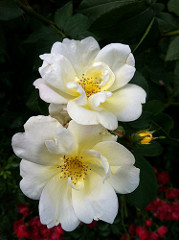

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

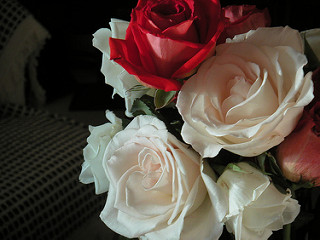

In [6]:
PIL.Image.open(str(roses[1]))

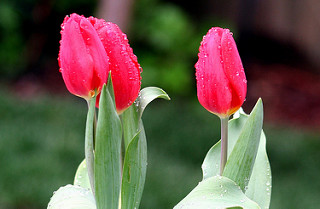

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

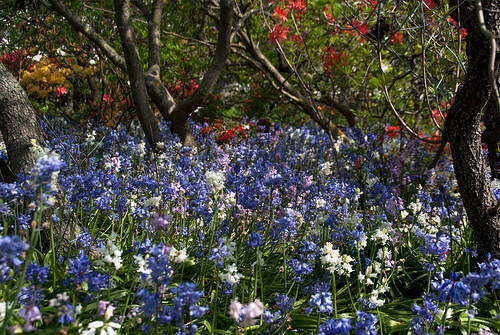

In [8]:
PIL.Image.open(str(tulips[1]))

In [9]:
batch_size = 32 
img_height = 180
img_width = 180
#The batch size, image height, and image width are used to define the size of the images.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(         
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


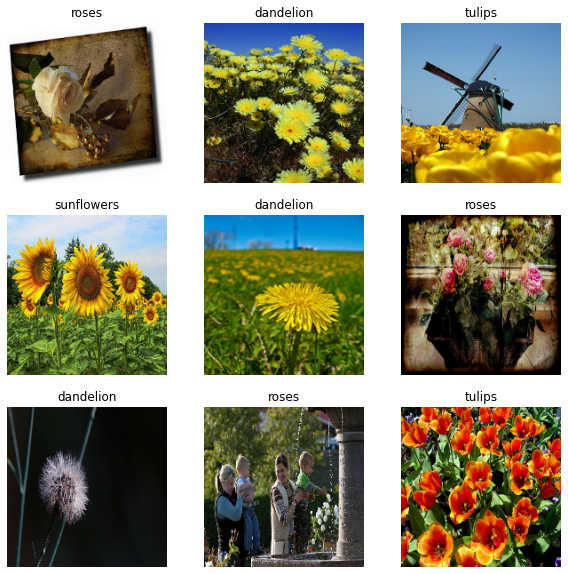

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:           
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255) 


In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [18]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])        

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
epochs= 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 25s 113ms/step - loss: 1.2804 - accuracy: 0.4486 - val_loss: 1.0471 - val_accuracy: 0.5559
Epoch 2/20
92/92 [==============================] - 4s 46ms/step - loss: 0.9594 - accuracy: 0.6178 - val_loss: 0.9224 - val_accuracy: 0.6267
Epoch 3/20
92/92 [==============================] - 4s 45ms/step - loss: 0.7853 - accuracy: 0.7040 - val_loss: 0.9126 - val_accuracy: 0.6376
Epoch 4/20
92/92 [==============================] - 4s 44ms/step - loss: 0.6064 - accuracy: 0.7728 - val_loss: 0.9624 - val_accuracy: 0.6362
Epoch 5/20
92/92 [==============================] - 4s 42ms/step - loss: 0.3887 - accuracy: 0.8607 - val_loss: 1.0244 - val_accuracy: 0.6362
Epoch 6/20
92/92 [==============================] - 4s 43ms/step - loss: 0.2010 - accuracy: 0.9336 - val_loss: 1.1821 - val_accuracy: 0.6580
Epoch 7/20
92/92 [==============================] - 4s 44ms/step - loss: 0.1135 - accuracy: 0.9659 - val_loss: 1.2181 - val_accuracy: 0.6335
Epoch 8/20


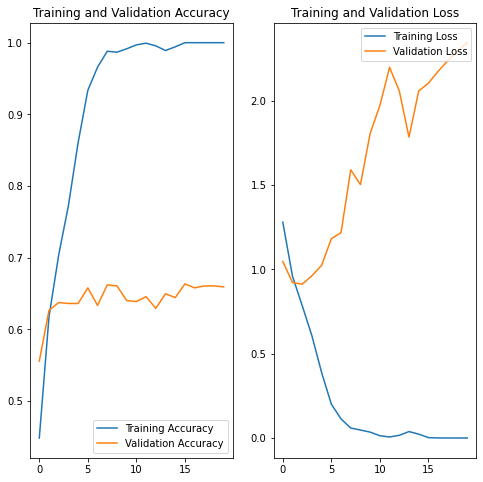

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)          

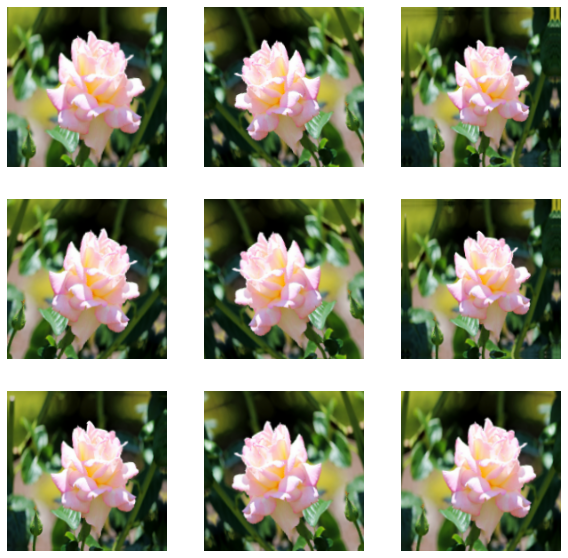

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/35
92/92 [==============================] - 9s 60ms/step - loss: 1.4114 - accuracy: 0.3988 - val_loss: 1.1200 - val_accuracy: 0.5450
Epoch 2/35
92/92 [==============================] - 5s 55ms/step - loss: 1.1092 - accuracy: 0.5548 - val_loss: 1.0482 - val_accuracy: 0.5790
Epoch 3/35
92/92 [==============================] - 5s 54ms/step - loss: 0.9933 - accuracy: 0.6090 - val_loss: 0.9491 - val_accuracy: 0.6090
Epoch 4/35
92/92 [==============================] - 5s 56ms/step - loss: 0.9017 - accuracy: 0.6499 - val_loss: 0.8856 - val_accuracy: 0.6335
Epoch 5/35
92/92 [==============================] - 5s 57ms/step - loss: 0.8647 - accuracy: 0.6621 - val_loss: 0.8315 - val_accuracy: 0.6826
Epoch 6/35
92/92 [==============================] - 5s 53ms/step - loss: 0.8052 - accuracy: 0.6836 - val_loss: 0.8086 - val_accuracy: 0.7044
Epoch 7/35
92/92 [==============================] - 5s 52ms/step - loss: 0.7510 - accuracy: 0.7136 - val_loss: 0.8714 - val_accuracy: 0.6567
Epoch 8/35
92

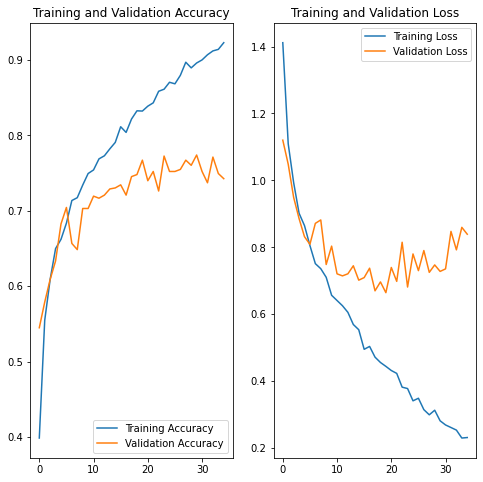

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [30]:
tulip_url = "https://5.imimg.com/data5/ZR/OO/EA/SELLER-34246236/tulip-flower-500x500.jpg"
tulip_path = tf.keras.utils.get_file('sunflowers', origin=tulip_url)

img = tf.keras.utils.load_img(
    tulip_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to tulips with a 99.98 percent confidence.
